In [1]:
import platform
print(platform.python_version())

3.6.5


In [2]:
import os
os.environ['MKL_THREADING_LAYER'] ='GNU'

In [3]:
import theano
import theano.tensor as T

# 심볼변수
### 스칼라, 벡터, 행렬 정의
- `dscalar`, `dvector`, `dmatrix`

In [4]:
x1 = T.dscalar('x1')
y1 = T.dscalar('y1')

x2 = T.dvector('x2')
y2 = T.dvector('y2')

x3 = T.dmatrix('x3')
y3 = T.dmatrix('y3')

type(x1), type(x2), type(x3)

(theano.tensor.var.TensorVariable,
 theano.tensor.var.TensorVariable,
 theano.tensor.var.TensorVariable)

# 그래프 정의
- 사칙연산과 Theano 수학함수로 다른 심볼변수 만들 수 있음
- graph: new & existing variable 연산관계

In [5]:
z1 = x1 + y1
type(z1)

theano.tensor.var.TensorVariable

In [6]:
u1 = T.exp(z1)
type(u1)

theano.tensor.var.TensorVariable

In [7]:
z2 = T.dot(x2, y2)
type(z2)

theano.tensor.var.TensorVariable

In [8]:
z3 = T.sum(x3) + T.mean(y3)
type(z3)

theano.tensor.var.TensorVariable

# 심볼 프린트 및 그래프 시각화
- `theano.printing.pprint`, `theano.printing.pydotprint`

In [9]:
theano.printing.pprint(x1)

'x1'

In [10]:
theano.printing.pprint(z1)

'(x1 + y1)'

In [11]:
theano.printing.pprint(u1)

'exp((x1 + y1))'

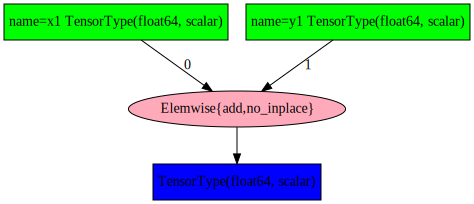

In [12]:
from IPython.display import SVG
SVG(theano.printing.pydotprint(z1, return_image=True, format='svg'))

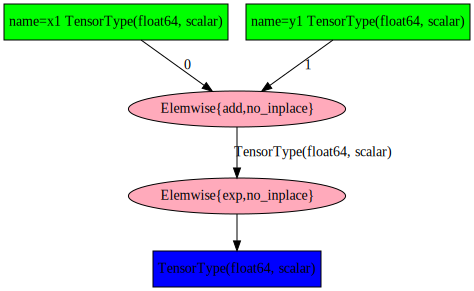

In [13]:
SVG(theano.printing.pydotprint(u1, return_image=True, format='svg'))

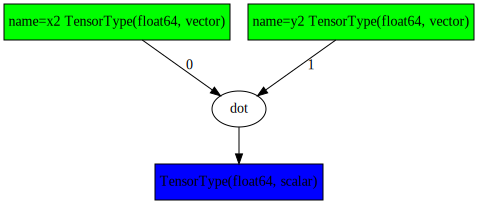

In [14]:
SVG(theano.printing.pydotprint(z2, return_image=True, format='svg'))

# 심볼 함수
- `theano.function`
- input & output 심볼변수 지정

- 일반함수

In [15]:
# x1+y1 = z1
f1 = theano.function(inputs=[x1, y1], outputs=z1)

In [16]:
f1(1, 2)

array(3.)

- 벡터 & 행렬 함수

In [17]:
# np.dot
f2 = theano.function([x2, y2], z2)
f2([1, 2], [3, 4])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


array(11.)

In [18]:
# np.sum + np.mean
f3 = theano.function([x3, y3], z3)
f3([[1], [2]], [[3], [4]])

array(6.5)

- 로지스틱함수

In [19]:
s1 = 1 / (1 + T.exp(-x1))
logistic = theano.function([x1], s1)
logistic(3)

array(0.95257413)

In [20]:
s2 = 1 / (1 + T.exp(-x2))
logistic2 = theano.function([x2], s2)
logistic2([0, 1])

array([0.5       , 0.73105858])

- 난수

In [21]:
from theano.tensor.shared_randomstreams import RandomStreams

srng = RandomStreams(99)
rv_u = srng.uniform()
f_rv_u = theano.function([], rv_u)

f_rv_u(), f_rv_u(), f_rv_u(), f_rv_u(), f_rv_u()

(array(0.51741339),
 array(0.31453479),
 array(0.29588247),
 array(0.35230635),
 array(0.83611852))

# 변수 갱신
- 공유 메모리에 저장 by `shared`
- 심볼그래프 사용X
- `function` and `updates`

eg. $w_{k+1} = w_k + x$

In [22]:
# 갱신되는 값: w
x = T.dscalar('x')
y = x
w = theano.shared(0.0, name='w')

update = theano.function([x], y, updates=[(w, w + x)])

w.set_value(f_rv_u())
w.get_value()

array(0.53626814)

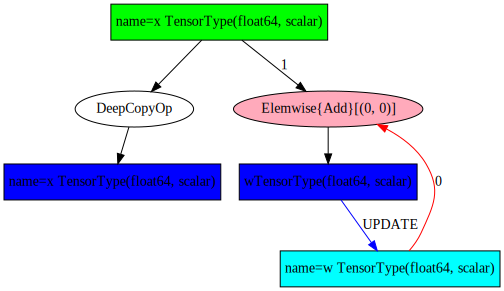

In [23]:
SVG(theano.printing.pydotprint(update, return_image=True, format='svg'))

In [24]:
update(1)
w.get_value()

array(1.53626814)

In [25]:
update(2)
w.get_value()

array(3.53626814)

# 그래프 최적화

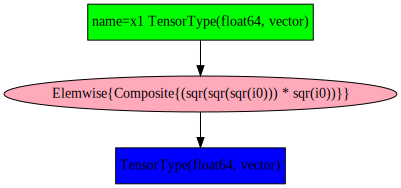

In [26]:
# x1을 10번 곱하지 않음
x1 = T.dvector('x1')
y1 = x1 ** 10
f1 = theano.function([x1], y1)

SVG(theano.printing.pydotprint(f1, return_image=True, format='svg'))

In [27]:
import numpy as np
x1 = np.ones(100000)

In [28]:
# 바보
%time x1 ** 10

CPU times: user 6.38 ms, sys: 1 ms, total: 7.39 ms
Wall time: 5.97 ms


array([1., 1., 1., ..., 1., 1., 1.])

In [29]:
# smart
%time f1(x1)

CPU times: user 549 µs, sys: 0 ns, total: 549 µs
Wall time: 556 µs


array([1., 1., 1., ..., 1., 1., 1.])

# 미분
- `grad`

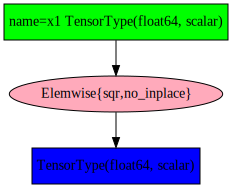

In [30]:
x1 = T.dscalar('x1')
y1 = x1 ** 2
fy1 = theano.function([x1], y1)

SVG(theano.printing.pydotprint(fy1.maker.fgraph.outputs[0], return_image=True, format='svg'))

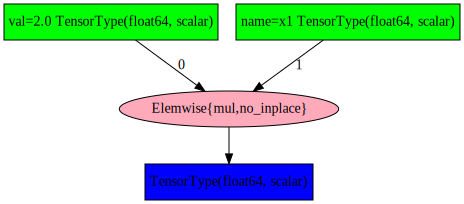

In [31]:
gy1 = T.grad(y1, x1)
fgy1 = theano.function([x1], gy1)

SVG(theano.printing.pydotprint(fgy1.maker.fgraph.outputs[0], return_image=True, format='svg'))

- sigmoid

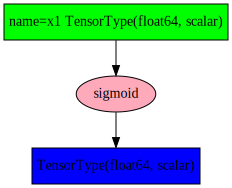

In [32]:
x1 = T.dscalar('x1')
s1 = 1 / (1 + T.exp(-x1))
logistic = theano.function([x1], s1)

SVG(theano.printing.pydotprint(logistic, return_image=True, format='svg'))

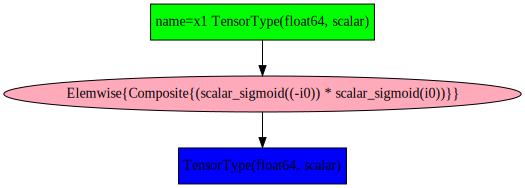

In [33]:
gs1 = T.grad(s1, x1)
dlogistic = theano.function([x1], gs1)

SVG(theano.printing.pydotprint(dlogistic, return_image=True, format='svg'))

In [34]:
xx = np.linspace(-5, 5, 100)
y1 = np.hstack([logistic(xi) for xi in xx])
y2 = np.hstack([dlogistic(xi) for xi in xx])

plt.plot(xx, y1, label='logistic func')
plt.plot(xx, y2, label='derivative of logistic func')
plt.title('logistic func and derivative of it')

plt.show()

# Perceptron 구현

In [115]:
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

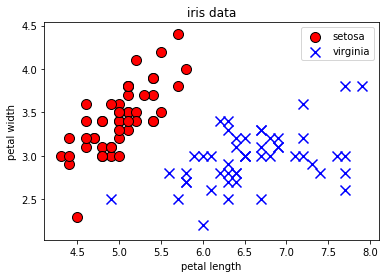

In [131]:
from sklearn.datasets import load_iris
iris = load_iris()

idx = np.in1d(iris.target, [0, 2])
x = iris.data[idx, 0:2]
y = iris.target[idx] - 1 #y = 1 or -1

x1 = x[:, 0]
x2 = x[:, 1]

plt.scatter(x1[y==-1], x2[y==-1], label='setosa', c='r', marker='o',\
           s=100, edgecolor='k')
plt.scatter(x1[y==1], x2[y==1], label='virginia', c='b', marker='x',\
           s=100, edgecolor='k')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend()
plt.title('iris data')
plt.show()

In [116]:
X = T.dmatrix('X')
Y = T.dvector('Y')
np.random.seed(2)

w = theano.shared(0.001 * np.random.randn(2), name='w')
b = theano.shared(0.001 * np.random.randn(1)[0], name='b')

z = T.tanh(T.dot(X, w) + b)
cost = T.sum(T.maximum(0, -Y * z))

gw, gb = T.grad(cost, [w, b])
mu = 1e-6
train = theano.function([X, Y], cost, updates=[(w, w - mu * gw), (b, b - mu * gb)])

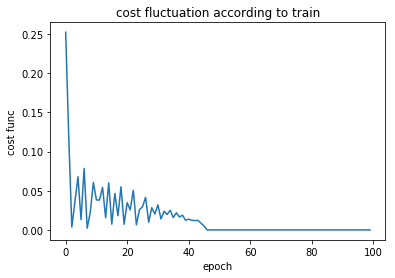

In [117]:
cost_history = []
for _ in range(100):
    cost_history.append(train(x, y))
    
plt.plot(cost_history)
plt.xlabel('epoch')
plt.ylabel('cost func')
plt.title('cost fluctuation according to train')
plt.show()

In [101]:
y_pred = T.sgn(z)
y_pred_func = theano.function([X], y_pred)

y_pred = y_pred_func(x)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

array([[49,  1],
       [ 0, 50]])

연습
1. y값은 0과 1이라는 값만 가진다.
2. 활성화 함수는 로지스틱 함수를 사용한다.
3. 코스트 함수는 다음과 같은 오차 제곱 함수를 사용한다.

In [133]:
np.random.seed(2)
y = (y+1) / 2
X = T.dmatrix('X')
Y = T.dvector('Y')

w = theano.shared(0.001 * np.random.randn(2), name='w')
b = theano.shared(0.001 * np.random.randn(1)[0], name='b')

z = 1 / (1 + T.exp(-(T.dot(X, w) + b)))
cost = T.sum((Y - z)**2)

gw, gb = T.grad(cost, [w, b])
mu = 1e-6

train = theano.function([X, Y], cost, updates=[(w, w - mu * gw), (b, b - mu * gb)])

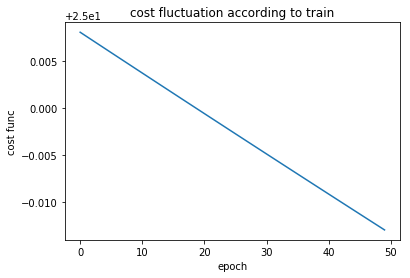

In [135]:
cost_history = []
for _ in range(50):
    cost_history.append(train(x, y))
    
plt.plot(cost_history)
plt.xlabel('epoch')
plt.ylabel('cost func')
plt.title('cost fluctuation according to train')
plt.show()

In [140]:
theano.printing.pprint(T.round(1.2))

'round_half_to_even(TensorConstant{1.2})'

In [142]:
y_pred = T.round(z)
y_pred_func = theano.function([X], y_pred)

y_pred = y_pred_func(x)
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])